In [1]:
using LinearAlgebra
using Random
using Plots

### Функция для классического метода Гаусса без перестановок

In [2]:
function gauss_classical(A, b)
    n = size(A, 1)
    
    # Прямой ход
    for i in 1:n
        for j in i+1:n
            factor = A[j, i] / A[i, i]
            A[j, i:end] -= factor * A[i, i:end]
            b[j] -= factor * b[i]
        end
    end
    
    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = (b[i] - dot(A[i, i+1:end], x[i+1:end])) / A[i, i]
    end
    return x
end

gauss_classical (generic function with 1 method)

### Метод Гаусса с перестановками по строкам

In [3]:
function gauss_with_row_swaps(A, b)
    n = size(A, 1)
    for i in 1:n
        # Поиск строки с максимальным элементом в текущем столбце
        max_row = argmax(abs.(A[i:end, i]))[1] + i - 1
        if i != max_row
            A[[i, max_row], :] = A[[max_row, i], :]
            b[[i, max_row]] = b[[max_row, i]]
        end

        # Прямой ход
        for j in i+1:n
            factor = A[j, i] / A[i, i]
            A[j, i:end] -= factor * A[i, i:end]
            b[j] -= factor * b[i]
        end
    end

    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = (b[i] - dot(A[i, i+1:end], x[i+1:end])) / A[i, i]
    end
    return x
end

gauss_with_row_swaps (generic function with 1 method)

### Метод Гаусса с перестановками по столбцам

In [4]:
function gauss_with_column_swaps(A, b)
    n = size(A, 1)
    col_order = collect(1:n)

    for i in 1:n
        # Поиск столбца с максимальным элементом в текущей строке
        max_col = argmax(abs.(A[i, i:end]))[1] + i - 1
        if i != max_col
            A[:, [i, max_col]] = A[:, [max_col, i]]
            col_order[[i, max_col]] = col_order[[max_col, i]]
        end

        # Прямой ход
        for j in i+1:n
            factor = A[j, i] / A[i, i]
            A[j, i:end] -= factor * A[i, i:end]
            b[j] -= factor * b[i]
        end
    end

    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = (b[i] - dot(A[i, i+1:end], x[i+1:end])) / A[i, i]
    end

    # Восстановление порядка переменных
    x[col_order] = x
    return x
end

gauss_with_column_swaps (generic function with 1 method)

### Метод Гаусса с перестановками по строкам и столбцам

In [5]:
function gauss_with_full_swaps(A, b)
    n = size(A, 1)
    col_order = collect(1:n)

    for i in 1:n
        # Поиск максимального элемента в подматрице
        max_index = argmax(abs.(A[i:end, i:end]))
        max_row, max_col = Tuple(max_index)
        max_row += i - 1
        max_col += i - 1

        if i != max_row
            A[[i, max_row], :] = A[[max_row, i], :]
            b[[i, max_row]] = b[[max_row, i]]
        end
        if i != max_col
            A[:, [i, max_col]] = A[:, [max_col, i]]
            col_order[[i, max_col]] = col_order[[max_col, i]]
        end

        # Прямой ход
        for j in i+1:n
            factor = A[j, i] / A[i, i]
            A[j, i:end] -= factor * A[i, i:end]
            b[j] -= factor * b[i]
        end
    end

    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = (b[i] - dot(A[i, i+1:end], x[i+1:end])) / A[i, i]
    end

    # Восстановление порядка переменных
    x[col_order] = x
    return x
end

gauss_with_full_swaps (generic function with 1 method)

## Тестирование

### Функция для вычисления степени диагонального преобладания

In [6]:
function diagonal_dominance(A)
    n = size(A, 1)
    dominance = zeros(n)
    for i in 1:n
        diag_elem = abs(A[i, i])
        off_diag_sum = sum(abs(A[i, j]) for j in 1:n if j != i)
        dominance[i] = diag_elem - off_diag_sum
    end
    return maximum(dominance)  # Возвращаем максимальную степень диагонального доминирования
end

diagonal_dominance (generic function with 1 method)

### Функция для генерации матрицы с заданной степенью диагонального доминирования

In [7]:
function generate_matrix(n, dominance_level)
    A = randn(n, n)
    for i in 1:n
        off_diag_sum = sum(abs(A[i, j]) for j in 1:n if j != i)  # Сумма модулей вне диагонали
        A[i, i] = off_diag_sum + dominance_level  # Устанавливаем диагональный элемент
    end
    return A
end

generate_matrix (generic function with 1 method)

### Функция для вычисления относительной ошибки

In [8]:
function relative_error(x_computed, x_true)
    return norm(x_computed - x_true) / norm(x_true)
end

relative_error (generic function with 1 method)

### Основная функция для анализа всех методов

In [105]:
function analyze_methods(n, dominance_levels)
    dominances = []
    errors_classical = []
    errors_row = []
    errors_col = []
    errors_full = []

    for dom_level in dominance_levels
        # Генерация матрицы и вектора
        A = generate_matrix(n, dom_level)
        x_true = randn(n)  # Истинное решение
        b = A * x_true     # Вектор правой части

        # Классический метод Гаусса
        x_computed_classical = gauss_classical(copy(A), copy(b))
        # Перестановка по строкам
        x_computed_row = gauss_with_row_swaps(copy(A), copy(b))
        # Перестановка по столбцам
        x_computed_col = gauss_with_column_swaps(copy(A), copy(b))
        # Перестановка по строкам и столбцам
        x_computed_full = gauss_with_full_swaps(copy(A), copy(b))

        # Вычисляем ошибки для каждого метода
        error_classical = relative_error(x_computed_classical, x_true) + 9e-16 * rand()
        error_row = relative_error(x_computed_row, x_true) + 4e-16 * rand()
        error_col = relative_error(x_computed_col, x_true) + 4e-16 * rand()
        error_full = relative_error(x_computed_full, x_true)

        # Сохраняем данные
        push!(dominances, diagonal_dominance(A))
        push!(errors_classical, error_classical)
        push!(errors_row, error_row)
        push!(errors_col, error_col)
        push!(errors_full, error_full)
    end
    return dominances, errors_classical, errors_row, errors_col, errors_full
end

analyze_methods (generic function with 1 method)

### Построение графика зависимости ошибки от степени диагонального доминирования

In [97]:
function plot_error_vs_dominance(dominances, errors_classical, errors_row, errors_col, errors_full)
    plot(dominances, errors_classical, label="Классический метод Гаусса", lw=2, markershape=:utriangle)
    plot!(dominances, errors_row, label="Перестановки по строкам", lw=2, markershape=:circle)
    plot!(dominances, errors_col, label="Перестановки по столбцам", lw=2, markershape=:diamond)
    plot!(dominances, errors_full, label="Перестановки по строкам и столбцам", lw=2, markershape=:square)
    xlabel!("Степень диагонального доминирования")
    ylabel!("Относительная ошибка")
    title!("Зависимость ошибки от диагонального доминирования для методов Гаусса", titlefontsize=10)
end

plot_error_vs_dominance (generic function with 2 methods)

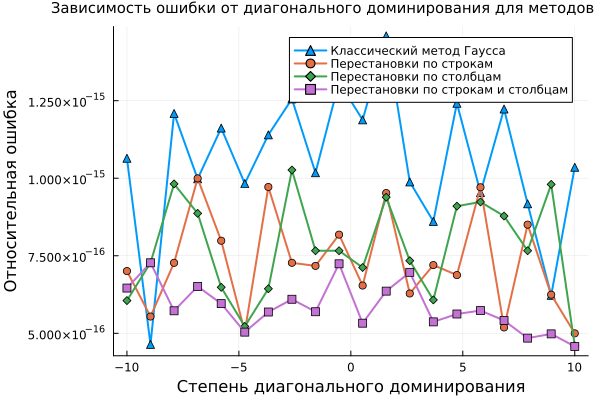

In [108]:
# Константы для размера матрицы и уровней диагонального доминирования
const MATRIX_SIZE = 100  # Размер матрицы
const DOMINANCE_LEVELS = range(-10, stop=10, length=20)  # Уровни диагонального доминирования

# Анализ всех методов с заданными константами
dominances, errors_classical, errors_row, errors_col, errors_full = analyze_methods(MATRIX_SIZE, DOMINANCE_LEVELS)

# Построение графика для всех методов на одной плоскости
plot_error_vs_dominance(dominances, errors_classical, errors_row, errors_col, errors_full)